In [38]:
import tensorflow as tf
import numpy as np

print(tf.__version__)
print(np.__version__)

2.6.0
1.21.4


In [39]:
from tensorflow import keras

def build_resnet_block(input_layer, num_cnn=3, channel=64, block_num=1, is_50=False, is_plain=False, total_blocks=4):
    x = input_layer

    if not is_50:
        for cnn_num in range(num_cnn):
            identity = x
            x = keras.layers.Conv2D(
                filters=channel,
                kernel_size=(3, 3),
                activation='relu',
                kernel_initializer='he_normal',
                padding='same',
                name=f'block{block_num}_conv{cnn_num}'
            )(x)
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Activation('relu')(x)
            x = keras.layers.Conv2D(
                filters=channel,
                kernel_size=(3, 3),
                kernel_initializer='he_normal',
                padding='same',
                name=f'block{block_num}_1_conv{cnn_num}'
            )(x)
            x = keras.layers.BatchNormalization()(x)

            if not is_plain:
                identity_channel = identity.shape.as_list()[-1]
                if identity_channel != channel:
                    identity = keras.layers.Conv2D(channel, kernel_size=(1, 1), strides=(1, 1), padding="same")(identity)
                x = keras.layers.Add()([x, identity])
            x = keras.layers.Activation('relu')(x)
    else:
        for cnn_num in range(num_cnn):
            identity = x
            x = keras.layers.Conv2D(
                filters=channel,
                kernel_size=(1, 1),
                activation='relu',
                kernel_initializer='he_normal',
                padding='same',
                name=f'block{block_num}_conv{cnn_num}'
            )(x)
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Activation('relu')(x)
            x = keras.layers.Conv2D(
                filters=channel,
                kernel_size=(3, 3),
                kernel_initializer='he_normal',
                padding='same',
                name=f'block{block_num}_1_conv{cnn_num}'
            )(x)
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Activation('relu')(x)
            x = keras.layers.Conv2D(
                filters=channel * 4,
                kernel_size=(1, 1),
                kernel_initializer='he_normal',
                padding='same',
                name=f'block{block_num}_2_conv{cnn_num}'
            )(x)
            x = keras.layers.BatchNormalization()(x)

            if not is_plain:
                identity_channel = identity.shape.as_list()[-1]
                if identity_channel != channel * 4:
                    identity = keras.layers.Conv2D(channel * 4, kernel_size=(1, 1), strides=(1, 1), padding="same")(identity)
                x = keras.layers.Add()([x, identity])
            x = keras.layers.Activation('relu')(x)

    if block_num < total_blocks:        
        x = keras.layers.MaxPooling2D(
            pool_size=(2, 2),
            strides=2,
            name=f'block{block_num}_pooling'
        )(x)

    return x

In [40]:
def build_resnet(input_shape=(32, 32, 3), num_cnn_list=[3, 4, 6, 3], channel_list=[64, 128, 256, 512], num_classes=10, is_50=False, is_plain=False):
    if is_50:
        num_cnn_list = [3, 4, 6, 3]
        channel_list = [64, 128, 256, 512]
    
    assert len(num_cnn_list) == len(channel_list),

    input_layer = keras.layers.Input(shape=input_shape)
    output = input_layer

    # Initial convolutional layer
    output = keras.layers.Conv2D(filters=64, kernel_size=(7, 7), strides=2, padding='same')(output)
    output = keras.layers.BatchNormalization()(output)
    output = keras.layers.Activation('relu')(output)

    # Initial max-pooling layer
    output = keras.layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(output)

    # Building ResNet blocks
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output = build_resnet_block(output, num_cnn=num_cnn, channel=channel, block_num=i+1, is_50=is_50, is_plain=is_plain, total_blocks=len(num_cnn_list))

    # Final layers and output
    output = keras.layers.GlobalAveragePooling2D()(output)
    output = keras.layers.Dense(512, activation='relu', name='fc1')(output)
    output = keras.layers.Dense(num_classes, activation='softmax', name='predictions')(output)

    model = keras.Model(inputs=input_layer, outputs=output)
    return model

In [41]:
# Build and summarize the ResNet-34 model
resnet_34 = build_resnet(input_shape=(32, 32, 3), is_50=False)
resnet_34.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 16, 16, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 16, 16, 64)   256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 16, 16, 64)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [42]:
# Build and summarize the ResNet-50 model
resnet_50 = build_resnet(input_shape=(32, 32, 3), is_50=True)
resnet_50.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 16, 16, 64)   9472        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_33 (BatchNo (None, 16, 16, 64)   256         conv2d_4[0][0]                   
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 16, 16, 64)   0           batch_normalization_33[0][0]     
____________________________________________________________________________________________

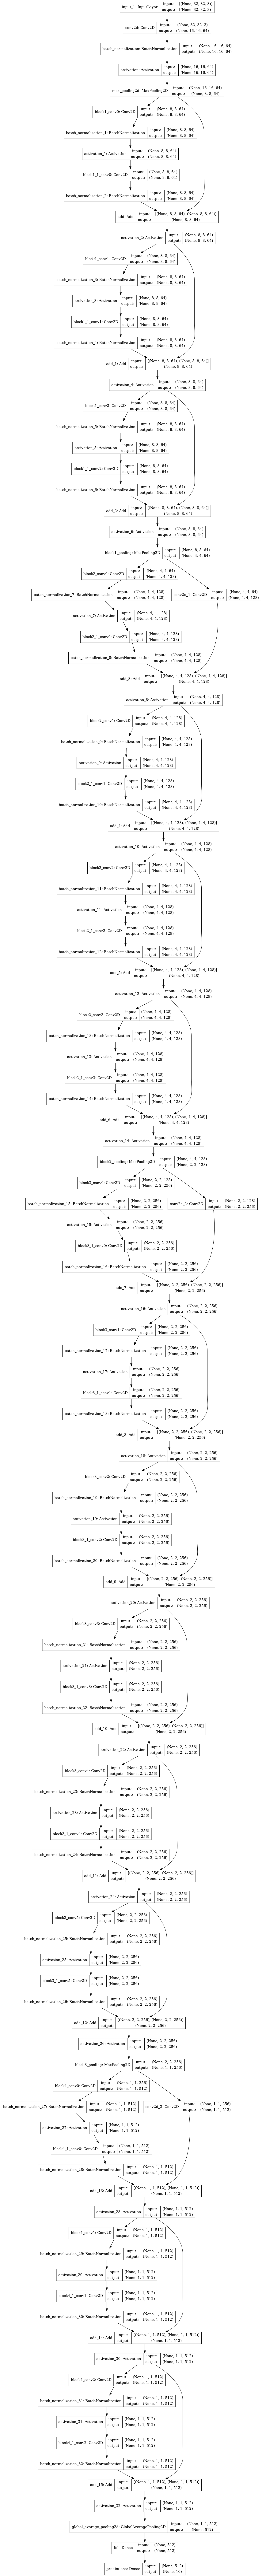

In [43]:
from tensorflow.keras.utils import plot_model

# Visualize the ResNet-34 model
plot_model(resnet_34, to_file='resnet_34.png', show_shapes=True, show_layer_names=True)

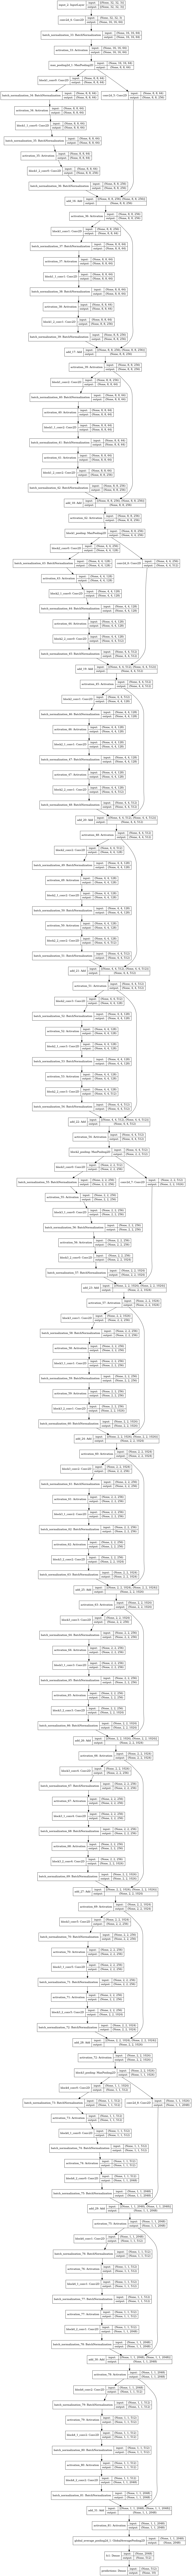

In [44]:
# Visualize the ResNet-50 model
plot_model(resnet_50, to_file='resnet_50.png', show_shapes=True, show_layer_names=True)

In [45]:
resnet_34 = build_resnet(is_50 = False)
resnet_50 = build_resnet(is_50 = True)
plain_resnet_34 = build_resnet(is_50 = False, is_plain = True)
plain_resnet_50 = build_resnet(is_50 = True, is_plain = True)

In [9]:
!pip install kaggle

In [10]:
# Change the permissions of the file
!chmod 600 /aiffel/.kaggle/kaggle.json

In [3]:
import os
train_path = 'cats-v-dogs/train'
len(os.listdir(train_path))

25000

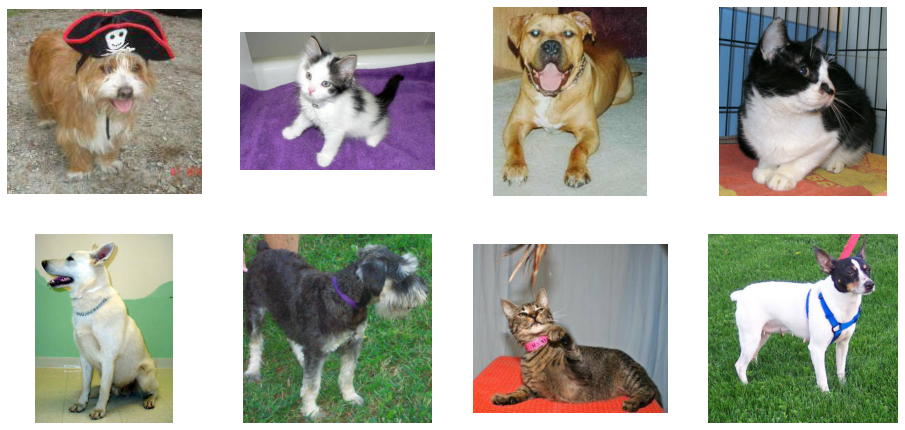

In [4]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import random

plt.figure(figsize=(16,16))

images = os.listdir(train_path)
for i in range(8):
    img = random.choice([x for x in images])
    fig = plt.subplot(4,4,i+1)
    fig.axis('off')
    img = mpimg.imread(os.path.join(train_path, img)) 
    fig.imshow(img) 

In [5]:
os.listdir(train_path)[:20]

['cat.6378.jpg',
 'dog.11042.jpg',
 'dog.334.jpg',
 'dog.1476.jpg',
 'dog.6747.jpg',
 'dog.616.jpg',
 'cat.4036.jpg',
 'cat.11519.jpg',
 'cat.3931.jpg',
 'dog.11730.jpg',
 'dog.11893.jpg',
 'dog.228.jpg',
 'cat.4549.jpg',
 'dog.1987.jpg',
 'cat.8402.jpg',
 'cat.12182.jpg',
 'cat.8221.jpg',
 'dog.6152.jpg',
 'dog.9603.jpg',
 'dog.662.jpg']

In [14]:
import numpy as np

src_dir = train_path

cats_train_dir = 'cats-v-dogs/training/cats'
cats_valid_dir = 'cats-v-dogs/validation/cats'

dogs_train_dir = 'cats-v-dogs/training/dogs'
dogs_valid_dir = 'cats-v-dogs/validation/dogs'

cats =[img for img in os.listdir(src_dir) if img[:3] == 'cat']

dogs =[img for img in os.listdir(src_dir) if img[:3] == 'dog']

np.random.seed(100)
cats_valid_sample = random.sample(cats, int(0.1*len(cats))) 
dogs_valid_sample = random.sample(dogs, int(0.1*len(dogs)))

In [15]:
for img in os.listdir(src_dir):
    src_img = os.path.join(src_dir, img)

    if img[:3] == 'cat':
        if img in cats_valid_sample:
            dest_img = os.path.join(cats_valid_dir, img)
        else:
            dest_img = os.path.join(cats_train_dir, img)

    elif img[:3] == 'dog':
        if img in dogs_valid_sample:
            dest_img = os.path.join(dogs_valid_dir, img)
        else:
            dest_img = os.path.join(dogs_train_dir, img)
    if not os.path.exists(dest_img):
        shutil.copyfile(src_img, dest_img)

In [16]:
print('No. of ALL cats : ', len(cats))
print('No. of cats for training: ', len(os.listdir(cats_train_dir)))
print('No. of cats for validation: ', len(os.listdir(cats_valid_dir)))

print('\nNo. of ALL dogs : ', len(dogs))
print('No. of dogs for training: ', len(os.listdir(dogs_train_dir)))
print('No. of dogs for validation: ', len(os.listdir(dogs_valid_dir)))

No. of ALL cats :  12500
No. of cats for training:  11250
No. of cats for validation:  1250

No. of ALL dogs :  12500
No. of dogs for training:  11250
No. of dogs for validation:  1250


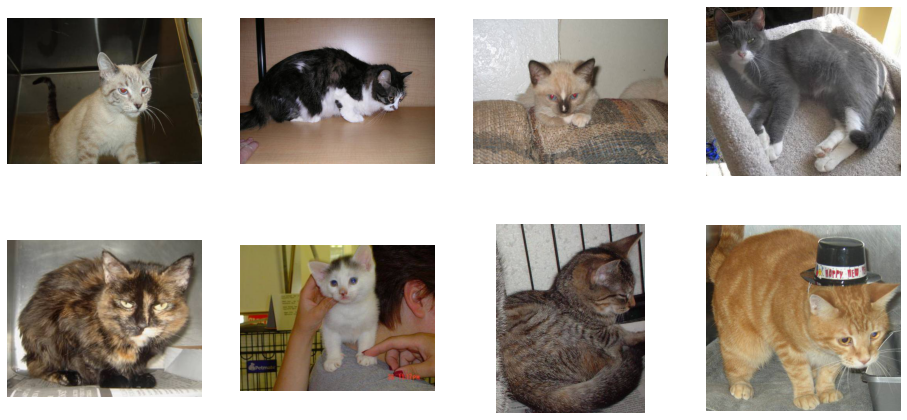

In [17]:
plt.figure(figsize=(16,16))

images = os.listdir(cats_train_dir)
for i in range(8):
    img = random.choice([x for x in images])
    fig = plt.subplot(4,4,i+1)
    fig.axis('off')
    img = mpimg.imread(os.path.join(cats_train_dir, img)) 
    fig.imshow(img) 

In [34]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import shutil

train_datagen = ImageDataGenerator(rescale=1/255)
valid_datagen = ImageDataGenerator(rescale=1/255)

train_dir = 'cats-v-dogs/training'
train_generator = train_datagen.flow_from_directory(train_dir, target_size=(224, 224), batch_size=32, class_mode='binary')

valid_dir = 'cats-v-dogs/validation'
valid_generator = valid_datagen.flow_from_directory(valid_dir,target_size=(224, 224), batch_size=32, class_mode='binary')

Found 22500 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


In [35]:
print(valid_generator.class_indices)

{'cats': 0, 'dogs': 1}


In [47]:
resnet_34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

In [48]:
history_34 = resnet_34.fit(
    train_generator,
    steps_per_epoch=int(len(train_generator)),
    validation_steps=int(len(valid_generator)),
    epochs=10,
    validation_data=valid_generator,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
704/704 [==============================] - 220s 237ms/step - loss: 0.6851 - accuracy: 0.6251 - val_loss: 0.8042 - val_accuracy: 0.5496
Epoch 2/10
704/704 [==============================] - 166s 235ms/step - loss: 0.5961 - accuracy: 0.6906 - val_loss: 0.8545 - val_accuracy: 0.5392
Epoch 3/10
704/704 [==============================] - 161s 229ms/step - loss: 0.5249 - accuracy: 0.7379 - val_loss: 0.7870 - val_accuracy: 0.6248
Epoch 4/10
704/704 [==============================] - 155s 220ms/step - loss: 0.4713 - accuracy: 0.7781 - val_loss: 1.1720 - val_accuracy: 0.5624
Epoch 5/10
704/704 [==============================] - 160s 226ms/step - loss: 0.4234 - accuracy: 0.8046 - val_loss: 0.8602 - val_accuracy: 0.6224
Epoch 6/10
704/704 [==============================] - 154s 218ms/step - loss: 0.3845 - accuracy: 0.8288 - val_loss: 0.5794 - val_accuracy: 0.7352
Epoch 7/10
704/704 [==============================] - 157s 222ms/step - loss: 0.3477 - accuracy: 0.8459 - val_loss: 0.5366 -

<AxesSubplot:title={'center':'Accuracy'}>

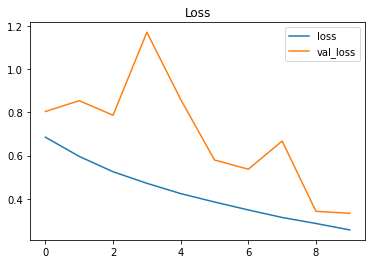

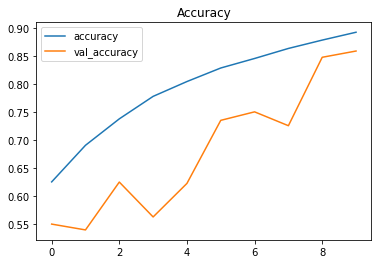

In [50]:
import pandas as pd

history_df = pd.DataFrame(history_34.history)

history_df.loc[:, ['loss', 'val_loss']].plot(title="Loss")
history_df.loc[:, ['accuracy', 'val_accuracy']].plot(title="Accuracy")

In [51]:
train_acc = resnet_34.evaluate(train_generator)[1]
valid_acc = resnet_34.evaluate(valid_generator)[1]
print("Accuracy on Training Data: ", train_acc)
print("Accuracy on Validation Data: ", valid_acc)

79/79 [==============================] - 8s 102ms/step - loss: 0.3321 - accuracy: 0.8592
Accuracy on Training Data:  0.8975111246109009
Accuracy on Validation Data:  0.8592000007629395


In [52]:
plain_resnet_34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

In [53]:
plain_history_34 = plain_resnet_34.fit(
    train_generator,
    steps_per_epoch=int(len(train_generator)),
    validation_steps=int(len(valid_generator)),
    epochs=10,
    validation_data=valid_generator,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
704/704 [==============================] - 174s 240ms/step - loss: 0.7428 - accuracy: 0.5361 - val_loss: 0.6950 - val_accuracy: 0.5200
Epoch 2/10
704/704 [==============================] - 156s 221ms/step - loss: 0.6924 - accuracy: 0.5407 - val_loss: 0.6990 - val_accuracy: 0.5196
Epoch 3/10
704/704 [==============================] - 162s 230ms/step - loss: 0.6920 - accuracy: 0.5421 - val_loss: 0.7678 - val_accuracy: 0.4896
Epoch 4/10
704/704 [==============================] - 167s 236ms/step - loss: 0.6885 - accuracy: 0.5506 - val_loss: 0.7621 - val_accuracy: 0.4872
Epoch 5/10
704/704 [==============================] - 155s 219ms/step - loss: 0.6851 - accuracy: 0.5595 - val_loss: 0.6919 - val_accuracy: 0.5568
Epoch 6/10
704/704 [==============================] - 168s 239ms/step - loss: 0.6816 - accuracy: 0.5657 - val_loss: 0.7757 - val_accuracy: 0.5480
Epoch 7/10
704/704 [==============================] - 159s 226ms/step - loss: 0.6762 - accuracy: 0.5774 - val_loss: 0.6788 -

<AxesSubplot:title={'center':'Accuracy'}>

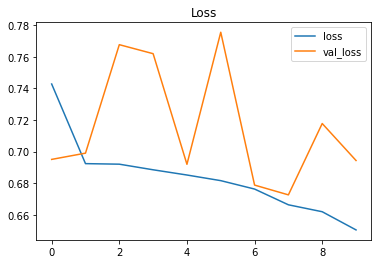

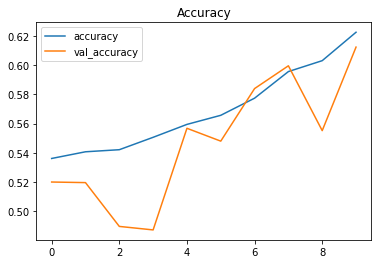

In [54]:
history_df = pd.DataFrame(plain_history_34.history)

history_df.loc[:, ['loss', 'val_loss']].plot(title="Loss")
history_df.loc[:, ['accuracy', 'val_accuracy']].plot(title="Accuracy")

In [55]:
resnet_50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

In [ ]:
history_50 = resnet_50.fit(
    train_generator,
    steps_per_epoch=int(len(train_generator)),
    validation_steps=int(len(valid_generator)),
    epochs=10,
    validation_data=valid_generator,
    verbose=1,
    use_multiprocessing=True,
)

In [ ]:
history_50 = pd.DataFrame(history.history)
history_50.loc[:,['loss','val_loss']].plot()
history_50.loc[:,['accuracy','val_accuracy']].plot()

In [ ]:
train_acc = resnet_50.evaluate(train_generator)[1]
valid_acc = resnet_50.evaluate(valid_generator)[1]
print("Accuracy on Training Data: ", train_acc)
print("Accuracy on Validation Data: ", valid_acc)